In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
%config Completer.use_jedi = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
import datetime

from tqdm.notebook import tqdm

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
import numpy as np

In [8]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [9]:
path_to_data = '../data/'

In [10]:
data_df = pd.read_csv(path_to_data + 'sessions_features/part-00005.csv')

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950324 entries, 0 to 950323
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   client                  950324 non-null  object 
 1   session_id              950324 non-null  object 
 2   last_application_id     950324 non-null  object 
 3   nunique_application_id  950324 non-null  int64  
 4   duration                950324 non-null  float64
 5   steps                   950324 non-null  int64  
 6   last_event_category     950324 non-null  object 
 7   nunique_event_category  950324 non-null  int64  
 8   nunique_event_label     950324 non-null  int64  
 9   max_timestamp           950324 non-null  object 
 10  multi_class_target      499672 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 79.8+ MB


In [12]:
numerical_features = ['nunique_application_id', 'duration', 'steps', 'nunique_event_category', 'nunique_event_label']
categorical_features = ['last_application_id']

Separate records with labels

In [13]:
to_predict = data_df[pd.isnull(data_df['multi_class_target'])]
to_train = data_df[~pd.isnull(data_df['multi_class_target'])]

Encoding categorical features

In [14]:
to_train.index

Int64Index([     0,      5,     13,     14,     16,     17,     20,     22,
                23,     25,
            ...
            950297, 950298, 950299, 950300, 950303, 950305, 950306, 950307,
            950316, 950318],
           dtype='int64', length=499672)

In [18]:
to_train = to_train.merge(pd.get_dummies(to_train['last_application_id']), left_index=True, right_index=True)

Encoding target labels

In [19]:
target_le = LabelEncoder()
target_le.fit(to_train['multi_class_target'])
to_train['multi_class_target_code'] = target_le.transform(to_train['multi_class_target'])

Make hold-out

In [20]:
train_val_df = to_train[:400000] 
test_df = to_train[400000:]  # hold out

In [162]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99672 entries, 764036 to 950318
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   client                                    99672 non-null  object 
 1   session_id                                99672 non-null  object 
 2   last_application_id                       99672 non-null  object 
 3   nunique_application_id                    99672 non-null  int64  
 4   duration                                  99672 non-null  float64
 5   steps                                     99672 non-null  int64  
 6   last_event_category                       99672 non-null  object 
 7   nunique_event_category                    99672 non-null  int64  
 8   nunique_event_label                       99672 non-null  int64  
 9   max_timestamp                             99672 non-null  object 
 10  multi_class_target          

In [36]:
features = train_val_df.drop(['client', 'session_id', 'last_application_id', 'last_event_category',
                              'max_timestamp', 'multi_class_target', 'multi_class_target_code'], axis=1).columns

In [37]:
categorical_features = ['last_application_id_code', 'last_event_category_code']

In [82]:
X_df = train_val_df[features]
# y_df = to_categorical(train_val_df['multi_class_target_code'], train_val_df['multi_class_target_code'].nunique())
y_df = train_val_df['multi_class_target_code']

In [83]:
y_df.shape

(400000,)

In [84]:
X_df.shape

(400000, 23)

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

In [150]:
X_val.values[211,:]

array([-0.12084509, -0.31984031,  0.43597766,  1.51956808,  1.10879199,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [146]:
y_train.values[211]

3

In [86]:
X_test = test_df[features]
# y_test = to_categorical(test_df['multi_class_target_code'], test_df['multi_class_target_code'].nunique())
y_test = test_df['multi_class_target_code']

Scale numerical features

In [87]:
for col in X_train.columns:
    if col in numerical_features:
        X_train[col] = StandardScaler().fit_transform(X_train[col].values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [149]:
for col in X_val.columns:
    if col in numerical_features:
        X_val[col] = StandardScaler().fit_transform(X_val[col].values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [161]:
for col in X_val.columns:
    if col in numerical_features:
        X_test[col] = StandardScaler().fit_transform(X_test[col].values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [45]:
from torch.utils.data import Dataset, DataLoader

In [46]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [151]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val.values).float(), torch.from_numpy(y_val.values).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.values).long())

In [270]:
EPOCHS = 100
BATCH_SIZE = 4096
LEARNING_RATE = 0.00001
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 10


In [271]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [295]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 1024)
        self.layer_2 = nn.Linear(1024, 4096)
        self.layer_3 = nn.Linear(4096, 10000)
        self.layer_4 = nn.Linear(10000, 4096)
        self.layer_5 = nn.Linear(4096, 512)
        self.layer_out = nn.Linear(512, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(4096)
        self.batchnorm3 = nn.BatchNorm1d(10000)
        self.batchnorm4 = nn.BatchNorm1d(4096)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        x = self.softmax(x)
        
        return x

In [296]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [297]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=23, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=4096, bias=True)
  (layer_3): Linear(in_features=4096, out_features=10000, bias=True)
  (layer_4): Linear(in_features=10000, out_features=4096, bias=True)
  (layer_5): Linear(in_features=4096, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=1)
)

In [298]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=23, out_features=1024, bias=True)
  (layer_2): Linear(in_features=1024, out_features=4096, bias=True)
  (layer_3): Linear(in_features=4096, out_features=10000, bias=True)
  (layer_4): Linear(in_features=10000, out_features=4096, bias=True)
  (layer_5): Linear(in_features=4096, out_features=512, bias=True)
  (layer_out): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=1)
)


In [299]:
def multi_acc(y_pred, y_test):
    # y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    y_pred_softmax = y_pred
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [300]:
from typing import Tuple

import torch


class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

In [301]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [302]:
f1_metric = F1Score('macro')

In [303]:
from sklearn.metrics import f1_score

In [304]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1 = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
#         print(y_train_pred.shape)
#         print(y_train_batch.shape)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_f1 = f1_score(y_train_batch.cpu().detach(), torch.max(y_train_pred, dim = 1)[1].cpu().detach(), average='macro')
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        train_epoch_f1 += train_f1.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        val_epoch_f1 = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_f1 = f1_score(y_val_batch.cpu(), torch.max(y_val_pred, dim = 1)[1].cpu(), average='macro')
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            val_epoch_f1 += val_f1.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    print('Train f1 = {0}'.format(train_epoch_f1/len(train_loader)))
    print('Val f1 = {0}'.format(val_epoch_f1/len(val_loader)))

Begin training.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.85610 | Val Loss: 1.73491 | Train Acc: 98.551| Val Acc: 100.000
Train f1 = 0.32657831778464536
Val f1 = 0.38611156685296033
Epoch 002: | Train Loss: 1.72864 | Val Loss: 1.72260 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.4065456470358379
Val f1 = 0.43583768701590064
Epoch 003: | Train Loss: 1.72030 | Val Loss: 1.71799 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.4386327798781669
Val f1 = 0.4440613160138645
Epoch 004: | Train Loss: 1.71718 | Val Loss: 1.71611 | Train Acc: 100.000| Val Acc: 100.000
Train f1 = 0.4458360257758572
Val f1 = 0.44729656273848895


KeyboardInterrupt: 

In [282]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        for x in y_pred_tags.cpu().numpy():
            y_pred_list.append(x)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [258]:
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:>

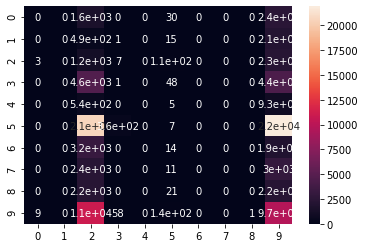

In [283]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

In [284]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4047
           1       0.00      0.00      0.00      2634
           2       0.02      0.32      0.05      3585
           3       0.00      0.00      0.00      9078
           4       0.00      0.00      0.00      1473
           5       0.02      0.00      0.00     42950
           6       0.00      0.00      0.00      5135
           7       0.00      0.00      0.00      5430
           8       0.00      0.00      0.00      4495
           9       0.19      0.46      0.27     20845

    accuracy                           0.11     99672
   macro avg       0.02      0.08      0.03     99672
weighted avg       0.05      0.11      0.06     99672



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [118]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(traindl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        print(labels.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

KeyError: 189483

In [ ]:
StandardScaler().fit_transform()

In [17]:
data_df['steps'].values.reshape(-1, 1).shape

(950324, 1)

In [19]:
StandardScaler().fit_transform(data_df['steps'].values.reshape(-1, 1)).shape

(950324, 1)

In [20]:
for col in data_df.columns:
    if col in numerical_features:
        data_df[col] = StandardScaler().fit_transform(data_df[col].values.reshape(-1, 1))

In [39]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950324 entries, 0 to 950323
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   client                  950324 non-null  object 
 1   session_id              950324 non-null  object 
 2   last_application_id     950324 non-null  int64  
 3   nunique_application_id  950324 non-null  int64  
 4   duration                950324 non-null  float64
 5   steps                   950324 non-null  int64  
 6   last_event_category     950324 non-null  int64  
 7   nunique_event_category  950324 non-null  int64  
 8   nunique_event_label     950324 non-null  int64  
 9   max_timestamp           950324 non-null  object 
 10  multi_class_target      499672 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 79.8+ MB


In [15]:
data_df['duration'].describe()

count    950324.000000
mean        153.265961
std         356.991700
min           0.000000
25%          11.996000
50%          29.234000
75%         117.056500
max       44259.645000
Name: duration, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='duration'>

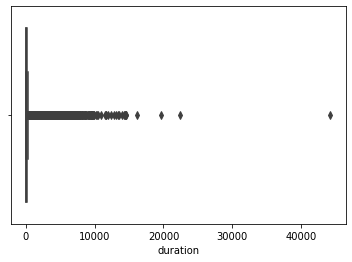

In [14]:
sns.boxplot(data_df['duration'])

In [10]:
le = LabelEncoder()

In [11]:
data_df['last_application_id'] = le.fit_transform(data_df['last_application_id'])

In [12]:
le = LabelEncoder()
data_df['last_event_category'] = le.fit_transform(data_df['last_event_category'])

In [13]:
train_df = data_df[pd.notnull(data_df['multi_class_target'])]
to_predict = data_df[~pd.notnull(data_df['multi_class_target'])]

In [14]:
le = LabelEncoder()
train_df['multi_class_target'] = le.fit_transform(train_df['multi_class_target'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
X_df = train_df.drop(['client', 'session_id', 'multi_class_target'], axis=1)
y_df = train_df[['multi_class_target']]

In [20]:
torch.tensor(y_df.values)

tensor([[5],
        [5],
        [5],
        ...,
        [9],
        [8],
        [5]])

In [21]:
one_hot = torch.nn.functional.one_hot(torch.tensor(y_df.values))

In [22]:
one_hot.shape

torch.Size([499672, 1, 10])

In [23]:
X_data = torch.tensor(X_df.values)

In [25]:
X_data.shape

torch.Size([499672, 7])

In [24]:
from torch.utils.data import Dataset

In [26]:
dataset = Dataset(X_data, one_hot)

NameError: name 'TensorDataset' is not defined

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
